In [2]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.utils import misc
from dcc import Parameters, AAV, OAV


import numpy as np
import pickle
import copy
from itertools import product

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt

import policy_pricer_python
from policy_pricer.cython_pricer import cython_pricer_naive
from policy_pricer import pricer_naive
from policy_pricer.cython_pricer import cython_pricer_optimized

[INFO] [2021-04-17 11:32:44,386] [tensorflow] - Enabling eager execution
[INFO] [2021-04-17 11:32:44,388] [tensorflow] - Enabling v2 tensorshape
[INFO] [2021-04-17 11:32:44,389] [tensorflow] - Enabling resource variables
[INFO] [2021-04-17 11:32:44,389] [tensorflow] - Enabling tensor equality
[INFO] [2021-04-17 11:32:44,390] [tensorflow] - Enabling control flow v2


In [3]:
params = Parameters()
aav = AAV(params)
sample_acc = np.array([5., 200])
aav.u(sample_acc[0], sample_acc[1])

[INFO] [2021-04-17 11:32:44,409] [AAV] - Instantiated @ AAV


-193.46379389522158

In [4]:
def convert_params_obj(params):
    retarr = np.array([params.lambdainf, params.kappa, params.delta10, params.delta11, params.delta2, params.c, params.rho], dtype=np.float64)
    return retarr

In [5]:
c_params = convert_params_obj(params)
c_params

array([ 0.1 ,  0.7 ,  0.02,  0.5 ,  1.  , 10.  ,  0.06])

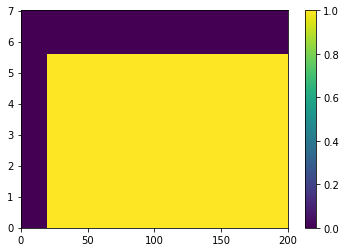

In [6]:
l = np.linspace(0, 7, 500)
w = np.linspace(0, 200, 500)
ww, ll = np.meshgrid(w, l)

autonomous_p = np.zeros_like(ww,dtype='int64')
degenerate_p = autonomous_p.copy()
# degenerate_p[:, 300:] = 1
degenerate_p[:400, 50:] = 1
plt.pcolormesh(ww, ll, degenerate_p, shading='auto')
plt.colorbar()
plt.show()

In [7]:
np.mean(policy_pricer_python.value_account(sample_acc, ww, ll, degenerate_p, params, np.array([0, 1.]), n_iterations=10000))

168.91336

In [7]:
aav.u(sample_acc[0], sample_acc[1])

-193.46379389522158

In [1]:
np.mean(cython_pricer_optimized.value_account_fast(sample_acc, ww, ll, degenerate_p, c_params, np.array([0, 5.]), n_iterations=10000))

NameError: name 'np' is not defined

aav.u(sa

Profile the pricers

In [16]:
ar = np.arange(0, 500., 7)
target = 600

print(cython_pricer_optimized.mySearchSorted_callable(ar, target))
print(np.searchsorted(ar, target, side='right'))
print(np.digitize(target, ar, right=True))

72
72
72


In [9]:
%%timeit
cython_pricer_optimized.mySearchSorted_callable(ar, target)

392 ns ± 5.8 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
%%timeit
np.searchsorted(ar, target, side='right')

1.98 µs ± 33.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
%%timeit
np.digitize(target, ar, right=True)

5.26 µs ± 357 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


tes

In [ ]:
np.mean(np.asarray(cython_pricer_optimized.value_account_fast(sample_acc, ww, ll, degenerate_p, c_params, np.array([0, 0.2]), n_iterations=10000)))

In [28]:
np.mean(np.asarray(cython_pricer_optimized.value_account(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]), n_iterations=10000)))

193.09948961640416

In [13]:
%%timeit
np.asarray(cython_pricer_optimized.value_account_fast(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]), n_iterations=10000))

75.1 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit
np.mean(cython_pricer_optimized.value_account(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]), n_iterations=10000))

1.72 s ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Timing the single collection cycle

In [13]:
test1 = [cython_pricer_optimized.single_collection_fast(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2])) for _ in range(100000)]
print(f"Mean: {np.mean(test1)} STD: {np.std(test1)}")

Mean: 108.74007629771648 STD: 49.188100668380585


In [14]:
test2 =  [cython_pricer_optimized.single_collection(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2])) for _ in range(100000)]
print(f"Mean: {np.mean(test2)} STD: {np.std(test2)}")

Mean: 108.39183298265611 STD: 49.30906947021554


In [20]:
%%timeit
cython_pricer_optimized.single_collection_fast(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]))

AttributeError: module 'policy_pricer.cython_pricer.cython_pricer_optimized' has no attribute 'single_collection_fast'

In [16]:
%%timeit
cython_pricer_optimized.single_collection(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]))

172 µs ± 1.88 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%%timeit
cython_pricer_naive.single_collection(sample_acc, ww, ll, autonomous_p, params, np.array([0, 0.2]))

242 µs ± 6.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
%%timeit
pricer_naive.single_collection(sample_acc, ww, ll, autonomous_p, params, np.array([0, 0.2]))

273 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Timing the full valuation

In [15]:
%%timeit
cython_pricer_optimized.value_account(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]), n_iterations=10000)

1.58 s ± 7.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit
cython_pricer_naive.value_account(sample_acc, ww, ll, autonomous_p, params, np.array([0, 0.2]), n_iterations=10000)

2.3 s ± 8.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
pricer_naive.value_account(sample_acc, ww, ll, autonomous_p, params, np.array([0, 0.2]), n_iterations=10000)

2.55 s ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
res = np.asarray(cython_pricer_optimized.value_account(sample_acc, ww, ll, autonomous_p, c_params, np.array([0, 0.2]), n_iterations=10000))
np.mean(res)

107.68750388473892

In [28]:
ython_pricer_optimized.value_account(sample_acc, ww, ll, degenerate_p, c_params, np.array([0, 0.2]), n_iterations=10000)

NameError: name 'ython_pricer_optimized' is not defined

In [19]:
res = pricer_naive.value_account(sample_acc, ww, ll, autonomous_p, params, np.array([0, 0.2]), n_iterations=10000)
np.mean(res)

108.2075

In [20]:
sample_acc = np.array([0.2, 200])
aav.u(sample_acc[0], sample_acc[1])

-111.16797478077257